# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# defining the function

def prob_drunk_given_positive(prob_drunk_prior, 
                              false_positive_rate, 
                              number_of_tests):
  posterior = prob_drunk_prior
  for test in range (0, number_of_tests):
    P_drunk = posterior # prior belief
    P_sober = 1 - P_drunk # complement of the prior belief
    P_pos_given_drunk = 1
    P_pos_given_sober = false_positive_rate
    numerator = (P_pos_given_drunk * P_drunk)
    denominator = ((P_pos_given_drunk * P_drunk) + (P_pos_given_sober * P_sober))
    posterior = numerator / denominator
  return posterior

In [14]:
# probability of drunk after 1 test
prob_drunk_given_positive(1/1000, 0.08, 1)

0.012357884330202669

In [15]:
# probability of drunk after 2 tests
prob_drunk_given_positive(1/1000, 0.08, 2)

0.13525210993291495

In [17]:
# probability of drunk after 3 tests
prob_drunk_given_positive(1/1000, 0.08, 3)

0.6615996951348605

In [18]:
# probability of drunk after 4 tests, this is how many tests it would take to
# be 95%+ sure the person is drunk beyond the legal limit
prob_drunk_given_positive(1/1000, 0.08, 4)

0.9606895076105054

In [0]:
# Imports
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# reading in the dataframe for Titanic
url = 'https://raw.githubusercontent.com/austinlasseter/pandas_visualization/master/data/titanic.csv'

titanic = pd.read_csv(url)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,male,22.0,7.2500,Southampton
1,1,1,female,38.0,71.2833,Cherbourg
2,1,3,female,26.0,7.9250,Southampton
3,1,1,female,35.0,53.1000,Southampton
4,0,3,male,35.0,8.0500,Southampton


In [25]:
# mean age
titanic['Age'].mean()

29.64209269662921

In [26]:
# frequentist approach for 95% confidence interval

conf_freq = stats.t.interval(0.95,
                             titanic.shape[0],
                             loc=titanic['Age'].mean(),
                             scale=stats.sem(titanic['Age'])
                             )
conf_freq

(28.57573413259152, 30.708451260666898)

In [27]:
# bayesian approach for 95% confidence interval
conf_bayes = stats.bayes_mvs(titanic['Age'], alpha=0.95)[0][1]
conf_bayes

(28.575731578809343, 30.708453814449076)

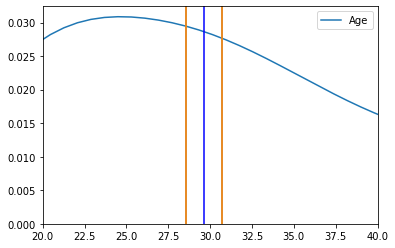

In [35]:
# plotted, but the differences are essentially the same
sns.kdeplot(titanic['Age'])
plt.xlim(20, 40)
plt.axvline(x=conf_bayes[0], color='purple')
plt.axvline(x=conf_bayes[1], color='purple')
plt.axvline(x=conf_freq[0], color='orange')
plt.axvline(x=conf_freq[1], color='orange')
plt.axvline(x=np.mean(titanic['Age']), color='blue');

In [36]:
# mean fare
titanic['Fare'].mean()

34.56725140449432

In [37]:
# frequentist approach for 95% confidence interval

conf_freq = stats.t.interval(0.95,
                             titanic.shape[0],
                             loc=titanic['Fare'].mean(),
                             scale=stats.sem(titanic['Fare'])
                             )
conf_freq

(30.672140508864565, 38.46236230012408)

In [38]:
# bayesian approach for 95% confidence interval
conf_bayes = stats.bayes_mvs(titanic['Fare'], alpha=0.95)[0][1]
conf_bayes

(30.672131180609462, 38.46237162837931)

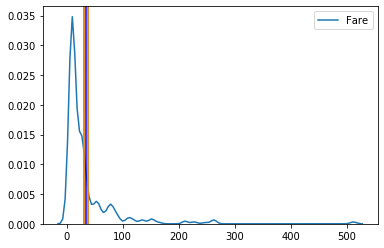

In [40]:
# plotted, but the differences are essentially the same
sns.kdeplot(titanic['Fare'])
plt.axvline(x=conf_bayes[0], color='purple')
plt.axvline(x=conf_bayes[1], color='purple')
plt.axvline(x=conf_freq[0], color='orange')
plt.axvline(x=conf_freq[1], color='orange')
plt.axvline(x=np.mean(titanic['Fare']), color='blue');

# **The Difference Between Bayesian and Frequentist Statistics**

**Frequentist** Statistics operates under the assumption that only repeatable
random events (coinflips) have probabilities. This means that they do not attach probabilities to any hypotheses. /n

**Bayesian** statistics operates in the realm where you can assign values to probabilities that aren't repeatable to represent uncertainty in an event or a hypothesis. This is useful for non-repeatable events such as a drug test or an election.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!